# Library

In [ ]:
import os
import random
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.applications import vgg16, vgg19, efficientnet, efficientnet_v2, mobilenet, mobilenet_v2, inception_v3, inception_resnet_v2, resnet, resnet_v2, xception, nasnet
from tensorflow.keras import Model
from PIL import Image 
import matplotlib.image as mpimg
import tempfile
from keras.models import load_model, save_model
from keras.layers import BatchNormalization

# Install Kaggle + Import Data


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d cihan063/autism-image-data

 96% 219M/229M [00:02<00:00, 137MB/s]
100% 229M/229M [00:02<00:00, 103MB/s]


In [ ]:
!mkdir autism

In [ ]:
!unzip -qq autism-image-data.zip -d autism
!ls autism

AutismDataset


In [ ]:
!ls autism/AutismDataset

consolidated  test  train  valid


In [ ]:
#Base
file_dir ='autism/AutismDataset/consolidated'

# Autist and Non-Autist
autist_dir = os.path.join(file_dir, 'Autistic')
nonautist_dir = os.path.join(file_dir, 'Non_Autistic')

print('total autist:', len(os.listdir(autist_dir)))
print('total nonautist:', len(os.listdir(nonautist_dir)))

total autist: 1470
total nonautist: 1470


## Split Folders

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio(file_dir, '/content/',  ratio=(0.75, 0.2, 0.05), group_prefix=None) 

Copying files: 2940 files [00:01, 2135.13 files/s]


In [ ]:
train_dir ='train'
val_dir = 'val'
test_dir = 'test'

# Train Dir
train_autist_dir = os.path.join(train_dir, 'Autistic')
train_nonautist_dir = os.path.join(train_dir, 'Non_Autistic')
print('total training autist:', len(os.listdir(train_autist_dir)))
print('total training nonautist:', len(os.listdir(train_nonautist_dir)))

# Val Dir
val_autist_dir = os.path.join(val_dir, 'Autistic')
val_nonautist_dir = os.path.join(val_dir, 'Non_Autistic')
print('total val autist:', len(os.listdir(val_autist_dir)))
print('total val nonautist:', len(os.listdir(val_nonautist_dir)))

# Test Dir
test_autist_dir = os.path.join(test_dir, 'Autistic')
test_nonautist_dir = os.path.join(test_dir, 'Non_Autistic')
print('total test autist:', len(os.listdir(test_autist_dir)))
print('total test nonautist:', len(os.listdir(test_nonautist_dir)))

total training autist: 1102
total training nonautist: 1102
total val autist: 294
total val nonautist: 294
total test autist: 74
total test nonautist: 74


# Pre-processing Image

In [ ]:
list_autism = os.listdir(train_dir)

In [ ]:
jumlah = 0

for x in list_autism:
  dc = os.path.join(train_dir, x)
  y = len(os.listdir(dc))
  print(x + ':', y)
  jumlah = jumlah + y

  namagbr = os.listdir(dc)
  for z in range(4):
    gbr_dc = os.path.join(dc, namagbr[z])
    gbr = Image.open(gbr_dc)
    print('ukuran', gbr.size)  
  print('/////////////////')

print('\nTotal Gambar :', jumlah)

Autistic: 1102
ukuran (265, 288)
ukuran (186, 244)
ukuran (318, 374)
ukuran (475, 559)
/////////////////
Non_Autistic: 1102
ukuran (381, 507)
ukuran (188, 224)
ukuran (367, 416)
ukuran (269, 283)
/////////////////

Total Gambar : 2204


Autistic


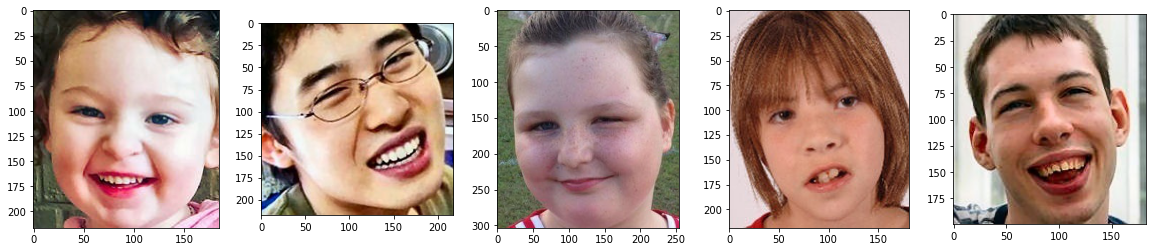

Non_Autistic


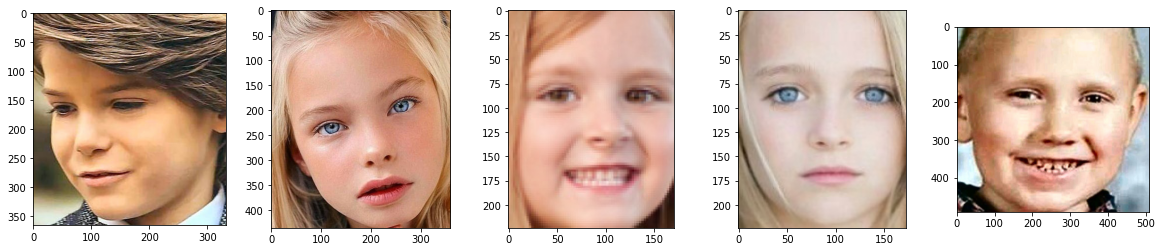

In [ ]:
# check images class
for item in list_autism:
  print(item)
  class_dir = os.path.join(train_dir,item)
  class_img = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, gbr_dc in enumerate(class_img[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, gbr_dc))
    plt.imshow(img)
  plt.show()

# Augmentation Image

In [ ]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

val_datagen = ImageDataGenerator(
    rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220,
)

val_generator = val_datagen.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58,
)

test_generator = val_datagen.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14,
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


# Modelling

## Self-Modelling

In [ ]:
model1 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(3,3),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(3,3),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(3,3),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor= "val_accuracy" , patience= 15, restore_best_weights=True)
mc = ModelCheckpoint(filepath="Model1_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history1 = model1.fit(
    train_generator, epochs=25, verbose=2, callbacks=[es, mc], 
    validation_data=val_generator, validation_steps=10) 

Epoch 1/25
11/11 - 44s - loss: 0.6999 - accuracy: 0.5032 - val_loss: 0.6897 - val_accuracy: 0.5224 - 44s/epoch - 4s/step
Epoch 2/25
11/11 - 30s - loss: 0.6914 - accuracy: 0.5100 - val_loss: 0.6876 - val_accuracy: 0.5155 - 30s/epoch - 3s/step
Epoch 3/25
11/11 - 30s - loss: 0.6815 - accuracy: 0.5635 - val_loss: 0.6858 - val_accuracy: 0.5155 - 30s/epoch - 3s/step
Epoch 4/25
11/11 - 30s - loss: 0.6907 - accuracy: 0.5313 - val_loss: 0.6873 - val_accuracy: 0.5052 - 30s/epoch - 3s/step
Epoch 5/25
11/11 - 31s - loss: 0.6816 - accuracy: 0.5531 - val_loss: 0.6628 - val_accuracy: 0.6138 - 31s/epoch - 3s/step
Epoch 6/25
11/11 - 30s - loss: 0.6729 - accuracy: 0.6093 - val_loss: 0.6987 - val_accuracy: 0.5431 - 30s/epoch - 3s/step
Epoch 7/25
11/11 - 30s - loss: 0.6835 - accuracy: 0.5603 - val_loss: 0.6571 - val_accuracy: 0.6000 - 30s/epoch - 3s/step
Epoch 8/25
11/11 - 30s - loss: 0.6565 - accuracy: 0.6361 - val_loss: 0.6313 - val_accuracy: 0.6672 - 30s/epoch - 3s/step
Epoch 9/25
11/11 - 30s - loss: 0

In [ ]:
model1.evaluate(train_generator)
model1.evaluate(val_generator)
model1.evaluate(test_generator)

11/11 [==============================] - 1s 49ms/step - loss: 0.6197 - accuracy: 0.6284


[0.6197378039360046, 0.6283783912658691]

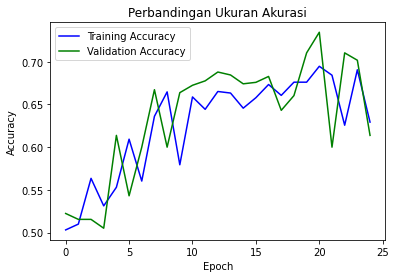

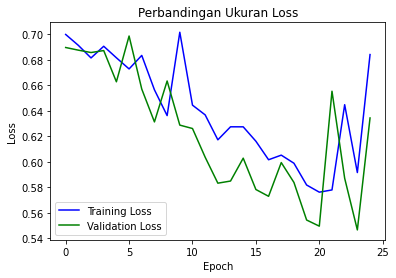

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history1.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history1.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history1.history['loss'], label='Training Loss', color='blue')
plt.plot(history1.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
pred1 = model1.predict_generator(test_generator)
predictions1 = np.argmax(pred1, axis=1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
cn_matrix1= confusion_matrix(true_classes, predictions1)
cn_matrix1

array([[63, 11],
       [64, 10]])

Text(0.5, 1.0, 'Confusion Matrix')

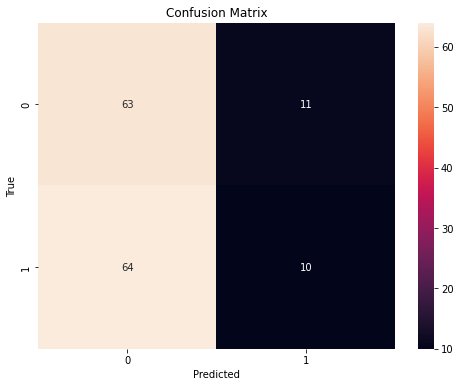

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix1, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions1)
print(cl_report)

              precision    recall  f1-score   support

           0       0.50      0.85      0.63        74
           1       0.48      0.14      0.21        74

    accuracy                           0.49       148
   macro avg       0.49      0.49      0.42       148
weighted avg       0.49      0.49      0.42       148



## VGG16

In [ ]:
preprocess_input = vgg16.preprocess_input

train_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator2 = train_datagen2.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator2 = val_datagen2.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator2 = val_datagen2.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
vgg16_model = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False)

for layer in vgg16_model.layers:
  layer.trainable = False
vgg16_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
last_layer = vgg16_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)                
x = tf.keras.layers.Dense(2, activation='softmax')(x)           

# Append the dense network to the base model
model2 = Model(vgg16_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc2 = ModelCheckpoint(filepath="Model2_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history2 = model2.fit(
    train_generator2, epochs=25, verbose=2, callbacks=[es, mc2], 
    validation_data=val_generator2, validation_steps=10) 

Epoch 1/25
11/11 - 43s - loss: 0.8301 - accuracy: 0.5903 - val_loss: 0.5845 - val_accuracy: 0.6862 - 43s/epoch - 4s/step
Epoch 2/25
11/11 - 16s - loss: 0.6487 - accuracy: 0.6760 - val_loss: 0.5601 - val_accuracy: 0.7172 - 16s/epoch - 1s/step
Epoch 3/25
11/11 - 16s - loss: 0.5945 - accuracy: 0.6838 - val_loss: 0.5566 - val_accuracy: 0.7069 - 16s/epoch - 1s/step
Epoch 4/25
11/11 - 16s - loss: 0.5570 - accuracy: 0.7278 - val_loss: 0.5611 - val_accuracy: 0.7069 - 16s/epoch - 1s/step
Epoch 5/25
11/11 - 17s - loss: 0.5446 - accuracy: 0.7282 - val_loss: 0.5563 - val_accuracy: 0.7293 - 17s/epoch - 2s/step
Epoch 6/25
11/11 - 16s - loss: 0.5261 - accuracy: 0.7309 - val_loss: 0.5341 - val_accuracy: 0.7379 - 16s/epoch - 1s/step
Epoch 7/25
11/11 - 17s - loss: 0.5101 - accuracy: 0.7482 - val_loss: 0.5638 - val_accuracy: 0.7379 - 17s/epoch - 2s/step
Epoch 8/25
11/11 - 16s - loss: 0.5100 - accuracy: 0.7468 - val_loss: 0.5421 - val_accuracy: 0.7379 - 16s/epoch - 1s/step
Epoch 9/25
11/11 - 17s - loss: 0

In [ ]:
model2.evaluate(train_generator2)
model2.evaluate(val_generator2)
model2.evaluate(test_generator2)  

11/11 [==============================] - 2s 83ms/step - loss: 0.5577 - accuracy: 0.7500


[0.5576735734939575, 0.75]

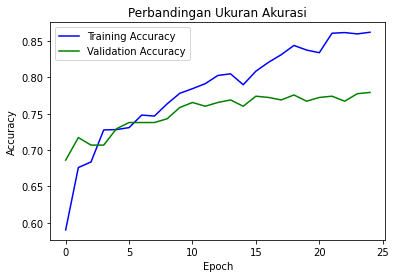

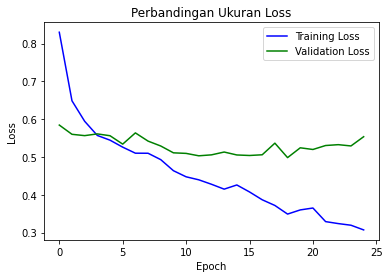

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history2.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history2.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred2 = model2.predict_generator(test_generator2)
predictions2 = np.argmax(pred2, axis=1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator2.classes
class_labels = list(test_generator2.class_indices.keys())

In [ ]:
cn_matrix2= confusion_matrix(true_classes, predictions2)
cn_matrix2

array([[31, 43],
       [46, 28]])

Text(0.5, 1.0, 'Confusion Matrix')

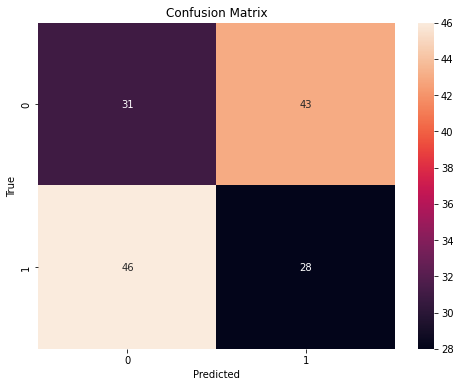

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix2, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions2)
print(cl_report)

              precision    recall  f1-score   support

           0       0.40      0.42      0.41        74
           1       0.39      0.38      0.39        74

    accuracy                           0.40       148
   macro avg       0.40      0.40      0.40       148
weighted avg       0.40      0.40      0.40       148



##VGG19

In [ ]:
preprocess_input2 = vgg19.preprocess_input

train_datagen3 = ImageDataGenerator(preprocessing_function=preprocess_input2)
val_datagen3 = ImageDataGenerator(preprocessing_function=preprocess_input2)

train_generator3 = train_datagen3.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator3 = val_datagen3.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)


test_generator3 = val_datagen3.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
vgg19_model = vgg19.VGG19(input_shape=(224, 224, 3), include_top=False)

for layer in vgg19_model.layers:
  layer.trainable = False
vgg19_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
last_layer2 = vgg19_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer2.output_shape)
last_output2 = last_layer2.output

last layer output shape:  (None, 7, 7, 512)


In [ ]:
x2 = tf.keras.layers.GlobalMaxPooling2D()(last_output2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Flatten()(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)
x2 = tf.keras.layers.Dense(512, activation='relu')(x2)                
x2 = tf.keras.layers.Dense(2, activation='softmax')(x2)           

# Append the dense network to the base model
model3 = Model(vgg19_model.input, x2)     

# Print the model summary. See your dense network connected at the end.
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc3 = ModelCheckpoint(filepath="Model3_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history3 = model3.fit(
    train_generator3, epochs=25, verbose=2, callbacks=[es, mc3], 
    validation_data=val_generator3, validation_steps=10) 

Epoch 1/25
11/11 - 21s - loss: 5.1828 - accuracy: 0.5299 - val_loss: 1.4335 - val_accuracy: 0.5741 - 21s/epoch - 2s/step
Epoch 2/25
11/11 - 20s - loss: 1.5024 - accuracy: 0.5490 - val_loss: 0.8675 - val_accuracy: 0.5914 - 20s/epoch - 2s/step
Epoch 3/25
11/11 - 19s - loss: 0.8155 - accuracy: 0.5658 - val_loss: 0.7023 - val_accuracy: 0.5672 - 19s/epoch - 2s/step
Epoch 4/25
11/11 - 19s - loss: 0.7330 - accuracy: 0.5563 - val_loss: 0.6993 - val_accuracy: 0.5603 - 19s/epoch - 2s/step
Epoch 5/25
11/11 - 19s - loss: 0.6904 - accuracy: 0.5767 - val_loss: 0.6871 - val_accuracy: 0.5724 - 19s/epoch - 2s/step
Epoch 6/25
11/11 - 19s - loss: 0.6646 - accuracy: 0.6112 - val_loss: 0.6696 - val_accuracy: 0.6017 - 19s/epoch - 2s/step
Epoch 7/25
11/11 - 19s - loss: 0.6581 - accuracy: 0.6152 - val_loss: 0.6653 - val_accuracy: 0.6190 - 19s/epoch - 2s/step
Epoch 8/25
11/11 - 19s - loss: 0.6836 - accuracy: 0.6012 - val_loss: 0.6666 - val_accuracy: 0.6172 - 19s/epoch - 2s/step
Epoch 9/25
11/11 - 20s - loss: 0

In [ ]:
model3.evaluate(train_generator3)
model3.evaluate(val_generator3)
model3.evaluate(test_generator3)

11/11 [==============================] - 1s 93ms/step - loss: 0.7395 - accuracy: 0.6959


[0.7395203113555908, 0.6959459185600281]

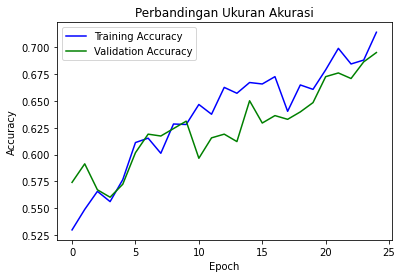

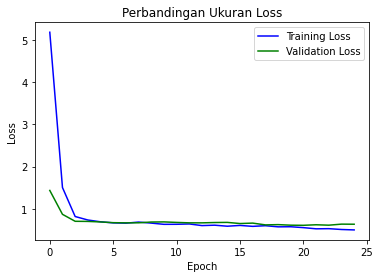

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history3.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history3.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history3.history['loss'], label='Training Loss', color='blue')
plt.plot(history3.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred3 = model3.predict_generator(test_generator3)
predictions3 = np.argmax(pred3, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator3.classes
class_labels = list(test_generator3.class_indices.keys())

In [ ]:
cn_matrix3= confusion_matrix(true_classes, predictions3)
cn_matrix3

array([[39, 35],
       [42, 32]])

Text(0.5, 1.0, 'Confusion Matrix')

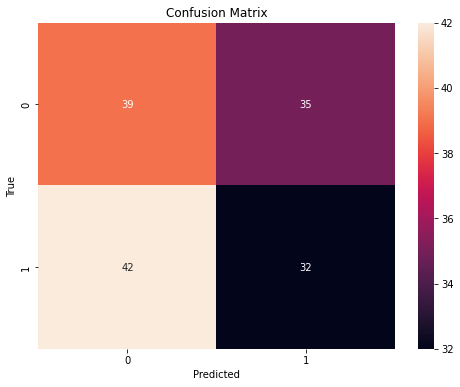

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix3, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions3)
print(cl_report)

              precision    recall  f1-score   support

           0       0.48      0.53      0.50        74
           1       0.48      0.43      0.45        74

    accuracy                           0.48       148
   macro avg       0.48      0.48      0.48       148
weighted avg       0.48      0.48      0.48       148



## Efficient Net B0

In [ ]:
preprocess_input3 = efficientnet.preprocess_input

train_datagen4 = ImageDataGenerator(preprocessing_function=preprocess_input3)
val_datagen4 = ImageDataGenerator(preprocessing_function=preprocess_input3)

train_generator4 = train_datagen4.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator4 = val_datagen4.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator4 = val_datagen4.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
en_model = efficientnet.EfficientNetB0(input_shape=(224, 224, 3), include_top=False)

for layer in en_model.layers:
  layer.trainable = False
en_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

In [ ]:
last_layer3 = en_model.get_layer('top_activation')
print('last layer output shape: ', last_layer3.output_shape)
last_output3 = last_layer3.output

last layer output shape:  (None, 7, 7, 1280)


In [ ]:
x3 = tf.keras.layers.GlobalMaxPooling2D()(last_output3)
x3 = tf.keras.layers.Dense(64, activation='relu')(x3)
x3 = tf.keras.layers.Flatten()(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(512, activation='relu')(x3)                
x3 = tf.keras.layers.Dense(2, activation='softmax')(x3)           

# Append the dense network to the base model
model4 = Model(en_model.input, x3)    

# Print the model summary. See your dense network connected at the end.
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

In [ ]:
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc4 = ModelCheckpoint(filepath="Model4_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history4 = model4.fit(
    train_generator4, epochs=25, verbose=2, callbacks=[es, mc4], 
    validation_data=val_generator4, validation_steps=10) 

Epoch 1/25
11/11 - 22s - loss: 0.9383 - accuracy: 0.5086 - val_loss: 0.6748 - val_accuracy: 0.5759 - 22s/epoch - 2s/step
Epoch 2/25
11/11 - 11s - loss: 0.6763 - accuracy: 0.5853 - val_loss: 0.6371 - val_accuracy: 0.6362 - 11s/epoch - 1s/step
Epoch 3/25
11/11 - 11s - loss: 0.6506 - accuracy: 0.6230 - val_loss: 0.6026 - val_accuracy: 0.6672 - 11s/epoch - 1s/step
Epoch 4/25
11/11 - 11s - loss: 0.6177 - accuracy: 0.6529 - val_loss: 0.5866 - val_accuracy: 0.6845 - 11s/epoch - 1s/step
Epoch 5/25
11/11 - 11s - loss: 0.6231 - accuracy: 0.6525 - val_loss: 0.5976 - val_accuracy: 0.6862 - 11s/epoch - 1s/step
Epoch 6/25
11/11 - 11s - loss: 0.6031 - accuracy: 0.6611 - val_loss: 0.5707 - val_accuracy: 0.7000 - 11s/epoch - 1s/step
Epoch 7/25
11/11 - 11s - loss: 0.5720 - accuracy: 0.6860 - val_loss: 0.5675 - val_accuracy: 0.6879 - 11s/epoch - 979ms/step
Epoch 8/25
11/11 - 11s - loss: 0.5968 - accuracy: 0.6760 - val_loss: 0.5769 - val_accuracy: 0.6897 - 11s/epoch - 978ms/step
Epoch 9/25
11/11 - 11s - l

In [ ]:
model4.evaluate(train_generator4)
model4.evaluate(val_generator4)
model4.evaluate(test_generator4)

11/11 [==============================] - 1s 57ms/step - loss: 0.5567 - accuracy: 0.7432


[0.556671679019928, 0.7432432174682617]

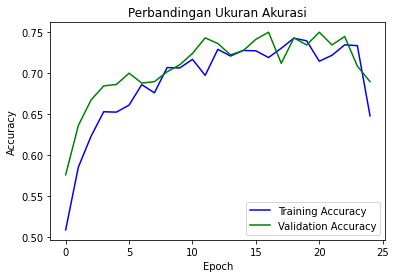

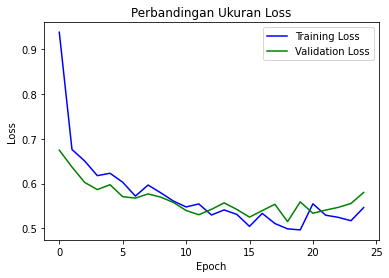

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history4.history['accuracy']))


#Plot training and validation accuracy per epoch
plt.plot(epochs, history4.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history4.history['loss'], label='Training Loss', color='blue')
plt.plot(history4.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred4 = model4.predict_generator(test_generator4)
predictions4 = np.argmax(pred4, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator4.classes
class_labels = list(test_generator4.class_indices.keys())

In [ ]:
cn_matrix4= confusion_matrix(true_classes, predictions4)
cn_matrix4

array([[23, 51],
       [31, 43]])

Text(0.5, 1.0, 'Confusion Matrix')

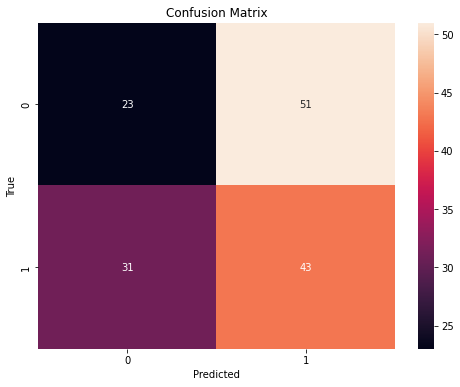

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix4, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions4)
print(cl_report)

              precision    recall  f1-score   support

           0       0.43      0.31      0.36        74
           1       0.46      0.58      0.51        74

    accuracy                           0.45       148
   macro avg       0.44      0.45      0.44       148
weighted avg       0.44      0.45      0.44       148



## Mobile Net

In [ ]:
preprocess_input4 = mobilenet.preprocess_input

train_datagen5 = ImageDataGenerator(preprocessing_function=preprocess_input4)
val_datagen5 = ImageDataGenerator(preprocessing_function=preprocess_input4)

train_generator5 = train_datagen5.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator5 = val_datagen5.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator5 = val_datagen5.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
mn_model = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False)

for layer in mn_model.layers:
  layer.trainable = False
mn_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
last_layer4 = mn_model.get_layer('conv_pw_13_relu')
print('last layer output shape: ', last_layer4.output_shape)
last_output4 = last_layer4.output

last layer output shape:  (None, 7, 7, 1024)


In [ ]:
x4 = tf.keras.layers.GlobalAveragePooling2D()(last_output4)
x4 = tf.keras.layers.Dense(64, activation='relu')(x4)
x4 = tf.keras.layers.Flatten()(x4)
x4 = tf.keras.layers.Dropout(0.5)(x4)
x4 = tf.keras.layers.Dense(512, activation='relu')(x4)                
x4 = tf.keras.layers.Dense(2, activation='softmax')(x4)           

# Append the dense network to the base model
model5 = Model(mn_model.input, x4)    

# Print the model summary. See your dense network connected at the end.
model5.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc5 = ModelCheckpoint(filepath="Model5_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history5 = model5.fit(
    train_generator5, epochs=25, verbose=2, callbacks=[es, mc5], 
    validation_data=val_generator5, validation_steps=10)

Epoch 1/25
11/11 - 15s - loss: 0.6674 - accuracy: 0.5885 - val_loss: 0.6078 - val_accuracy: 0.6534 - 15s/epoch - 1s/step
Epoch 2/25
11/11 - 10s - loss: 0.5956 - accuracy: 0.6747 - val_loss: 0.5592 - val_accuracy: 0.6914 - 10s/epoch - 945ms/step
Epoch 3/25
11/11 - 10s - loss: 0.5448 - accuracy: 0.7250 - val_loss: 0.5058 - val_accuracy: 0.7397 - 10s/epoch - 943ms/step
Epoch 4/25
11/11 - 10s - loss: 0.5209 - accuracy: 0.7368 - val_loss: 0.4997 - val_accuracy: 0.7621 - 10s/epoch - 949ms/step
Epoch 5/25
11/11 - 10s - loss: 0.4959 - accuracy: 0.7595 - val_loss: 0.4875 - val_accuracy: 0.7534 - 10s/epoch - 930ms/step
Epoch 6/25
11/11 - 10s - loss: 0.4707 - accuracy: 0.7795 - val_loss: 0.4631 - val_accuracy: 0.7724 - 10s/epoch - 948ms/step
Epoch 7/25
11/11 - 10s - loss: 0.4595 - accuracy: 0.7799 - val_loss: 0.4724 - val_accuracy: 0.7655 - 10s/epoch - 928ms/step
Epoch 8/25
11/11 - 10s - loss: 0.4457 - accuracy: 0.7972 - val_loss: 0.4592 - val_accuracy: 0.7586 - 10s/epoch - 930ms/step
Epoch 9/25


In [ ]:
model5.evaluate(train_generator5)
model5.evaluate(val_generator5)
model5.evaluate(test_generator5)

11/11 [==============================] - 1s 50ms/step - loss: 0.4046 - accuracy: 0.8176


[0.4046313166618347, 0.8175675868988037]

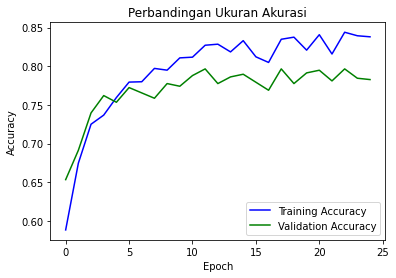

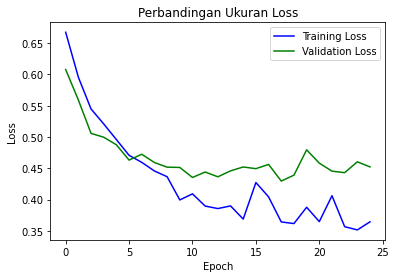

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history5.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history5.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history5.history['loss'], label='Training Loss', color='blue')
plt.plot(history5.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred5 = model5.predict_generator(test_generator5)
predictions5 = np.argmax(pred5, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator5.classes
class_labels = list(test_generator5.class_indices.keys())

In [ ]:
cn_matrix5= confusion_matrix(true_classes, predictions5)
cn_matrix5

array([[40, 34],
       [47, 27]])

Text(0.5, 1.0, 'Confusion Matrix')

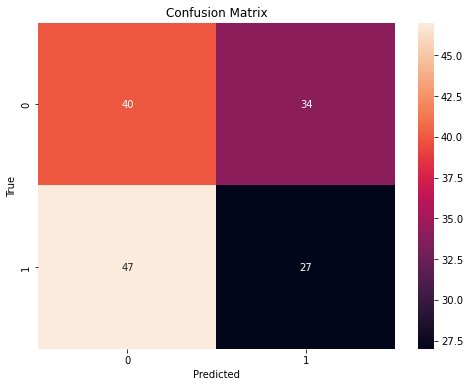

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix5, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions5, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.46      0.54      0.50        74
Non_Autistic       0.44      0.36      0.40        74

    accuracy                           0.45       148
   macro avg       0.45      0.45      0.45       148
weighted avg       0.45      0.45      0.45       148



## Mobile Net V2

In [ ]:
preprocess_input5 = mobilenet_v2.preprocess_input

train_datagen6 = ImageDataGenerator(preprocessing_function=preprocess_input5)
val_datagen6 = ImageDataGenerator(preprocessing_function=preprocess_input5)

train_generator6 = train_datagen6.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator6 = val_datagen6.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator6 = val_datagen6.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
mn2_model = mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False)

for layer in mn2_model.layers:
  layer.trainable = False
mn2_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
last_layer5 = mn2_model.get_layer('out_relu')
print('last layer output shape: ', last_layer5.output_shape)
last_output5 = last_layer5.output

last layer output shape:  (None, 7, 7, 1280)


In [ ]:
x5 = tf.keras.layers.GlobalAveragePooling2D()(last_output5)
x5 = tf.keras.layers.Dense(64, activation='relu')(x5)
x5 = tf.keras.layers.Flatten()(x5)
x5 = tf.keras.layers.Dropout(0.5)(x5)
x5 = tf.keras.layers.Dense(512, activation='relu')(x5)                
x5 = tf.keras.layers.Dense(2, activation='softmax')(x5)           

# Append the dense network to the base model
model6 = Model(mn2_model.input, x5)    

# Print the model summary. See your dense network connected at the end.
model6.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
model6.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc6 = ModelCheckpoint(filepath="Model6_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history6 = model6.fit(
    train_generator6, epochs=25, verbose=2, callbacks=[es, mc6], 
    validation_data=val_generator6, validation_steps=10) 

Epoch 1/25
11/11 - 15s - loss: 0.6324 - accuracy: 0.6429 - val_loss: 0.5263 - val_accuracy: 0.7397 - 15s/epoch - 1s/step
Epoch 2/25
11/11 - 11s - loss: 0.5364 - accuracy: 0.7332 - val_loss: 0.5223 - val_accuracy: 0.7534 - 11s/epoch - 969ms/step
Epoch 3/25
11/11 - 11s - loss: 0.5316 - accuracy: 0.7459 - val_loss: 0.5138 - val_accuracy: 0.7672 - 11s/epoch - 966ms/step
Epoch 4/25
11/11 - 10s - loss: 0.5030 - accuracy: 0.7718 - val_loss: 0.4776 - val_accuracy: 0.7603 - 10s/epoch - 929ms/step
Epoch 5/25
11/11 - 10s - loss: 0.4748 - accuracy: 0.7768 - val_loss: 0.4700 - val_accuracy: 0.7534 - 10s/epoch - 920ms/step
Epoch 6/25
11/11 - 10s - loss: 0.4476 - accuracy: 0.7858 - val_loss: 0.4680 - val_accuracy: 0.7638 - 10s/epoch - 920ms/step
Epoch 7/25
11/11 - 11s - loss: 0.4409 - accuracy: 0.7981 - val_loss: 0.5068 - val_accuracy: 0.7397 - 11s/epoch - 995ms/step
Epoch 8/25
11/11 - 11s - loss: 0.4325 - accuracy: 0.7976 - val_loss: 0.4517 - val_accuracy: 0.7776 - 11s/epoch - 967ms/step
Epoch 9/25


In [ ]:
model6.evaluate(train_generator6)
model6.evaluate(val_generator6)
model6.evaluate(test_generator6)

11/11 [==============================] - 1s 54ms/step - loss: 0.4558 - accuracy: 0.8041


[0.4558257460594177, 0.8040540814399719]

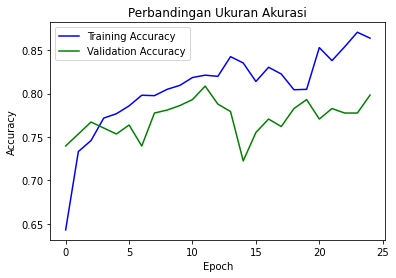

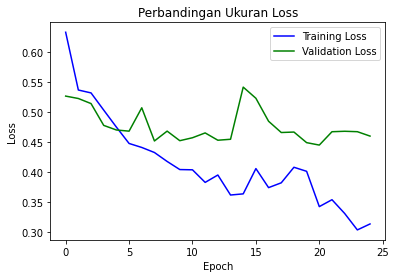

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history6.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history6.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history6.history['loss'], label='Training Loss', color='blue')
plt.plot(history6.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred6 = model6.predict_generator(test_generator6)
predictions6 = np.argmax(pred6, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator6.classes
class_labels = list(test_generator6.class_indices.keys())   

In [ ]:
cn_matrix6= confusion_matrix(true_classes, predictions6)
cn_matrix6

array([[39, 35],
       [32, 42]])

Text(0.5, 1.0, 'Confusion Matrix')

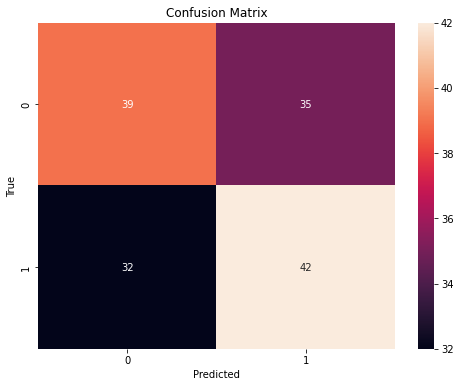

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix6, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions6, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.55      0.53      0.54        74
Non_Autistic       0.55      0.57      0.56        74

    accuracy                           0.55       148
   macro avg       0.55      0.55      0.55       148
weighted avg       0.55      0.55      0.55       148



## Inception V3

In [ ]:
preprocess_input6 = inception_v3.preprocess_input

train_datagen7 = ImageDataGenerator(preprocessing_function=preprocess_input6)
val_datagen7 = ImageDataGenerator(preprocessing_function=preprocess_input6)

train_generator7 = train_datagen7.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator7 = val_datagen7.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator7 = val_datagen7.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
inc_model = inception_v3.InceptionV3(input_shape=(224, 224, 3), include_top=False)

for layer in inc_model.layers:
  layer.trainable = False
inc_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)           

In [ ]:
last_layer6 = inc_model.get_layer('mixed10')
print('last layer output shape: ', last_layer6.output_shape)
last_output6 = last_layer6.output

last layer output shape:  (None, 5, 5, 2048)


In [ ]:
x6 = tf.keras.layers.GlobalAveragePooling2D()(last_output6)
x6 = tf.keras.layers.Flatten()(x6)
x6 = tf.keras.layers.Dropout(0.5)(x6)
x6 = tf.keras.layers.Dense(512, activation='relu')(x6)                
x6 = tf.keras.layers.Dense(2, activation='softmax')(x6)           

# Append the dense network to the base model
model7 = Model(inc_model.input, x6)    

# Print the model summary. See your dense network connected at the end.
model7.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)                     )                                                           

In [ ]:
model7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc7 = ModelCheckpoint(filepath="Model7_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history7 = model7.fit(
    train_generator7, epochs=25, verbose=2, callbacks=[es, mc7], 
    validation_data=val_generator7, validation_steps=10)

Epoch 1/25
11/11 - 24s - loss: 1.5318 - accuracy: 0.5299 - val_loss: 0.7674 - val_accuracy: 0.5086 - 24s/epoch - 2s/step
Epoch 2/25
11/11 - 12s - loss: 0.6636 - accuracy: 0.6207 - val_loss: 0.6118 - val_accuracy: 0.6534 - 12s/epoch - 1s/step
Epoch 3/25
11/11 - 11s - loss: 0.6374 - accuracy: 0.6157 - val_loss: 0.6142 - val_accuracy: 0.6293 - 11s/epoch - 1s/step
Epoch 4/25
11/11 - 12s - loss: 0.5771 - accuracy: 0.6965 - val_loss: 0.5736 - val_accuracy: 0.7103 - 12s/epoch - 1s/step
Epoch 5/25
11/11 - 12s - loss: 0.5445 - accuracy: 0.7273 - val_loss: 0.5407 - val_accuracy: 0.7345 - 12s/epoch - 1s/step
Epoch 6/25
11/11 - 12s - loss: 0.5257 - accuracy: 0.7355 - val_loss: 0.5203 - val_accuracy: 0.7448 - 12s/epoch - 1s/step
Epoch 7/25
11/11 - 11s - loss: 0.5223 - accuracy: 0.7346 - val_loss: 0.5163 - val_accuracy: 0.7310 - 11s/epoch - 1s/step
Epoch 8/25
11/11 - 11s - loss: 0.5070 - accuracy: 0.7541 - val_loss: 0.5051 - val_accuracy: 0.7414 - 11s/epoch - 1s/step
Epoch 9/25
11/11 - 11s - loss: 0

In [ ]:
model7.evaluate(train_generator7)
model7.evaluate(val_generator7)
model7.evaluate(test_generator7)

11/11 [==============================] - 2s 59ms/step - loss: 0.4422 - accuracy: 0.8176


[0.4422198534011841, 0.8175675868988037]

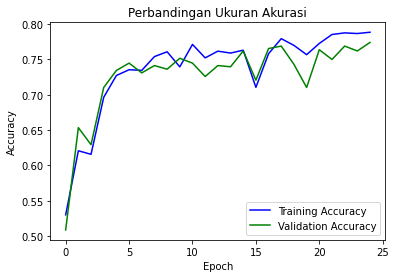

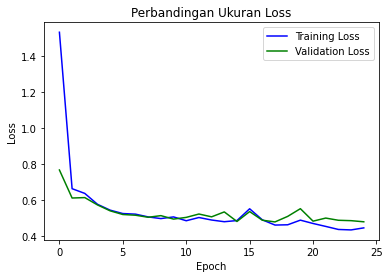

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history7.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history7.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history7.history['loss'], label='Training Loss', color='blue')
plt.plot(history7.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred7 = model7.predict_generator(test_generator7)
predictions7 = np.argmax(pred7, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator7.classes
class_labels = list(test_generator7.class_indices.keys())   

In [ ]:
cn_matrix7 = confusion_matrix(true_classes, predictions7)
cn_matrix7

array([[34, 40],
       [35, 39]])

Text(0.5, 1.0, 'Confusion Matrix')

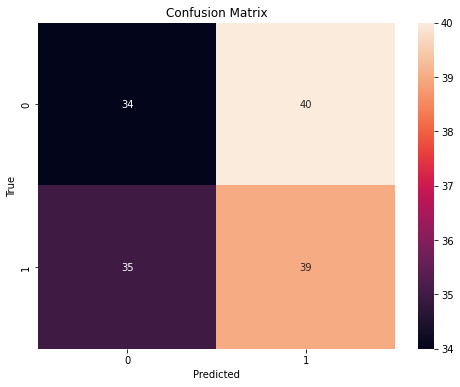

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix7, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions7, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.49      0.46      0.48        74
Non_Autistic       0.49      0.53      0.51        74

    accuracy                           0.49       148
   macro avg       0.49      0.49      0.49       148
weighted avg       0.49      0.49      0.49       148



## Inception Resnet V2

In [ ]:
preprocess_input7 = inception_resnet_v2.preprocess_input

train_datagen8 = ImageDataGenerator(preprocessing_function=preprocess_input7)
val_datagen8 = ImageDataGenerator(preprocessing_function=preprocess_input7)

train_generator8 = train_datagen8.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator8 = val_datagen8.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator8 = val_datagen8.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
inc_res_model = inception_resnet_v2.InceptionResNetV2(input_shape=(224, 224, 3), include_top=False)

for layer in inc_res_model.layers:
  layer.trainable = False
inc_res_model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_97 (Conv2D)             (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_97[0][0]']              
 ormalization

In [ ]:
last_layer7 = inc_res_model.get_layer('conv_7b_ac')
print('last layer output shape: ', last_layer7.output_shape)
last_output7 = last_layer7.output

last layer output shape:  (None, 5, 5, 1536)


In [ ]:
x7 = tf.keras.layers.GlobalMaxPooling2D()(last_output7)
x7 = tf.keras.layers.Dense(64, activation='relu')(x7)
x7 = tf.keras.layers.Flatten()(x7)
x7 = tf.keras.layers.Dropout(0.5)(x7)
x7 = tf.keras.layers.Dense(512, activation='relu')(x7)                
x7 = tf.keras.layers.Dense(2, activation='softmax')(x7)           

# Append the dense network to the base model
model8 = Model(inc_res_model.input, x7)    

# Print the model summary. See your dense network connected at the end.
model8.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_97 (Conv2D)             (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_97[0][0]']              
 ormalization)                  )                                                           

In [ ]:
model8.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc8 = ModelCheckpoint(filepath="Model8_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history8 = model8.fit(
    train_generator8, epochs=25, verbose=2, callbacks=[es, mc8], 
    validation_data=val_generator8, validation_steps=10)

Epoch 1/25
11/11 - 40s - loss: 0.8794 - accuracy: 0.5204 - val_loss: 0.6807 - val_accuracy: 0.5190 - 40s/epoch - 4s/step
Epoch 2/25
11/11 - 17s - loss: 0.6997 - accuracy: 0.5563 - val_loss: 0.6571 - val_accuracy: 0.5431 - 17s/epoch - 2s/step
Epoch 3/25
11/11 - 17s - loss: 0.6745 - accuracy: 0.5658 - val_loss: 0.6158 - val_accuracy: 0.6621 - 17s/epoch - 2s/step
Epoch 4/25
11/11 - 17s - loss: 0.6583 - accuracy: 0.6093 - val_loss: 0.6363 - val_accuracy: 0.6862 - 17s/epoch - 2s/step
Epoch 5/25
11/11 - 15s - loss: 0.6435 - accuracy: 0.6034 - val_loss: 0.6090 - val_accuracy: 0.6862 - 15s/epoch - 1s/step
Epoch 6/25
11/11 - 17s - loss: 0.6399 - accuracy: 0.5912 - val_loss: 0.5927 - val_accuracy: 0.7034 - 17s/epoch - 2s/step
Epoch 7/25
11/11 - 15s - loss: 0.6300 - accuracy: 0.6171 - val_loss: 0.6049 - val_accuracy: 0.7017 - 15s/epoch - 1s/step
Epoch 8/25
11/11 - 18s - loss: 0.6091 - accuracy: 0.6429 - val_loss: 0.5836 - val_accuracy: 0.7172 - 18s/epoch - 2s/step
Epoch 9/25
11/11 - 16s - loss: 0

In [ ]:
model8.evaluate(train_generator8)
model8.evaluate(val_generator8)
model8.evaluate(test_generator8)

11/11 [==============================] - 2s 101ms/step - loss: 0.5442 - accuracy: 0.7095


[0.544150710105896, 0.7094594836235046]

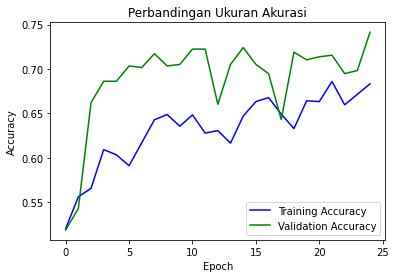

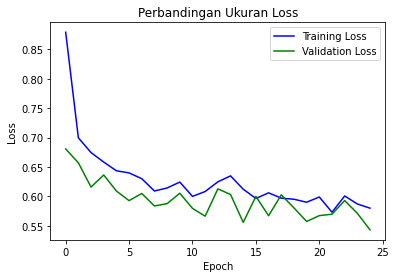

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history8.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history8.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history8.history['loss'], label='Training Loss', color='blue')
plt.plot(history8.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred8 = model8.predict_generator(test_generator8)
predictions8 = np.argmax(pred8, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator8.classes
class_labels = list(test_generator8.class_indices.keys())   

In [ ]:
cn_matrix8 = confusion_matrix(true_classes, predictions8)
cn_matrix8

array([[27, 47],
       [32, 42]])

Text(0.5, 1.0, 'Confusion Matrix')

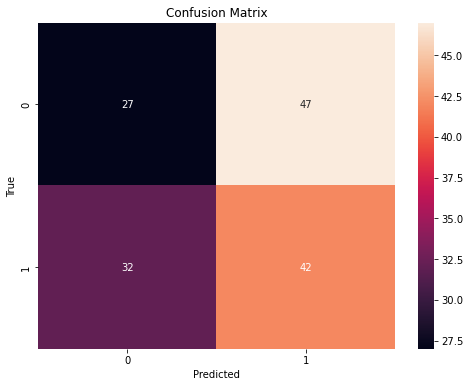

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix8, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes , predictions8)
print(cl_report)

              precision    recall  f1-score   support

           0       0.46      0.36      0.41        74
           1       0.47      0.57      0.52        74

    accuracy                           0.47       148
   macro avg       0.46      0.47      0.46       148
weighted avg       0.46      0.47      0.46       148



## Resnet50 

In [ ]:
preprocess_input8 = resnet.preprocess_input

train_datagen9 = ImageDataGenerator(preprocessing_function=preprocess_input8)
val_datagen9 = ImageDataGenerator(preprocessing_function=preprocess_input8)

train_generator9 = train_datagen9.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator9 = val_datagen9.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator9 = val_datagen9.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
res_model = resnet.ResNet50(input_shape=(224, 224, 3), include_top=False)

for layer in res_model.layers:
  layer.trainable = False
res_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
last_layer8 = res_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer8.output_shape)
last_output8 = last_layer8.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
x8 = tf.keras.layers.GlobalMaxPooling2D()(last_output8)
x8 = tf.keras.layers.Dense(64, activation='relu')(x8)
x8 = tf.keras.layers.Flatten()(x8)
x8 = tf.keras.layers.Dropout(0.5)(x8)
x8 = tf.keras.layers.Dense(512, activation='relu')(x8)                
x8 = tf.keras.layers.Dense(2, activation='softmax')(x8)           

# Append the dense network to the base model
model9 = Model(res_model.input, x8)    

# Print the model summary. See your dense network connected at the end.
model9.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model9.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc9 = ModelCheckpoint(filepath="Model9_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history9 = model9.fit(
    train_generator9, epochs=25, verbose=2, callbacks=[es, mc9], 
    validation_data=val_generator9, validation_steps=10)

Epoch 1/25
11/11 - 23s - loss: 1.9898 - accuracy: 0.5000 - val_loss: 0.7166 - val_accuracy: 0.5172 - 23s/epoch - 2s/step
Epoch 2/25
11/11 - 14s - loss: 0.7725 - accuracy: 0.5227 - val_loss: 0.7107 - val_accuracy: 0.4845 - 14s/epoch - 1s/step
Epoch 3/25
11/11 - 14s - loss: 0.7019 - accuracy: 0.4927 - val_loss: 0.6934 - val_accuracy: 0.5138 - 14s/epoch - 1s/step
Epoch 4/25
11/11 - 14s - loss: 0.6923 - accuracy: 0.5127 - val_loss: 0.6926 - val_accuracy: 0.5138 - 14s/epoch - 1s/step
Epoch 5/25
11/11 - 15s - loss: 0.6893 - accuracy: 0.5327 - val_loss: 0.6878 - val_accuracy: 0.5517 - 15s/epoch - 1s/step
Epoch 6/25
11/11 - 14s - loss: 0.6791 - accuracy: 0.5662 - val_loss: 0.6725 - val_accuracy: 0.6138 - 14s/epoch - 1s/step
Epoch 7/25
11/11 - 15s - loss: 0.6725 - accuracy: 0.5880 - val_loss: 0.6689 - val_accuracy: 0.6466 - 15s/epoch - 1s/step
Epoch 8/25
11/11 - 14s - loss: 0.6613 - accuracy: 0.5994 - val_loss: 0.6688 - val_accuracy: 0.6190 - 14s/epoch - 1s/step
Epoch 9/25
11/11 - 15s - loss: 0

In [ ]:
model9.evaluate(train_generator9)
model9.evaluate(val_generator9)
model9.evaluate(test_generator9)

11/11 [==============================] - 1s 72ms/step - loss: 0.5530 - accuracy: 0.7500


[0.5530107021331787, 0.75]

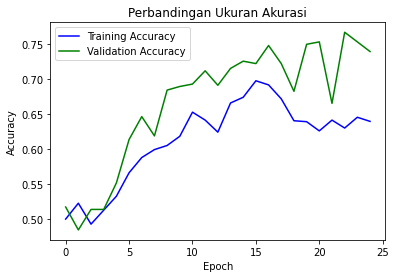

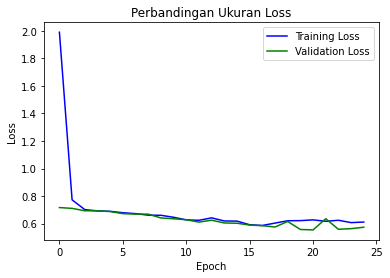

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history9.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history9.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history9.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history9.history['loss'], label='Training Loss', color='blue')
plt.plot(history9.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred9 = model9.predict_generator(test_generator9)
predictions9 = np.argmax(pred9, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator9.classes
class_labels = list(test_generator9.class_indices.keys())   

In [ ]:
cn_matrix9 = confusion_matrix(true_classes, predictions9)
cn_matrix9

array([[33, 41],
       [30, 44]])

Text(0.5, 1.0, 'Confusion Matrix')

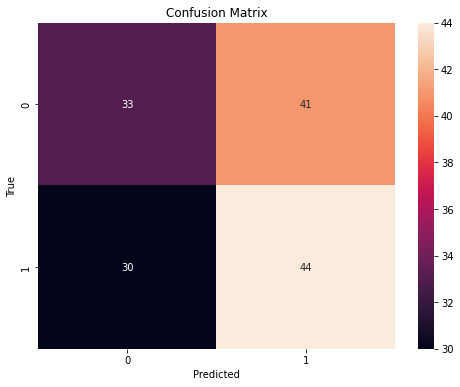

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix9, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions9, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.52      0.45      0.48        74
Non_Autistic       0.52      0.59      0.55        74

    accuracy                           0.52       148
   macro avg       0.52      0.52      0.52       148
weighted avg       0.52      0.52      0.52       148



## Resnet101

In [ ]:
res_101_model = resnet.ResNet101(input_shape=(224, 224, 3), include_top=False)

for layer in res_101_model.layers:
  layer.trainable = False
res_101_model.summary()

171458560/171446536 [==============================] - 2s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [ ]:
last_layer9 = res_101_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer9.output_shape)
last_output9 = last_layer9.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
x9 = tf.keras.layers.GlobalMaxPooling2D()(last_output9)
x9 = tf.keras.layers.Dense(64, activation='relu')(x9)
x9 = tf.keras.layers.Flatten()(x9)
x9 = tf.keras.layers.Dropout(0.5)(x9)
x9 = tf.keras.layers.Dense(512, activation='relu')(x9)                
x9 = tf.keras.layers.Dense(2, activation='softmax')(x9)           

# Append the dense network to the base model
model10 = Model(res_101_model.input, x9)    

# Print the model summary. See your dense network connected at the end.
model10.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model10.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc10 = ModelCheckpoint(filepath="Model10_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history10 = model10.fit(
    train_generator9, epochs=25, verbose=2, callbacks=[es, mc10], 
    validation_data=val_generator9, validation_steps=10)

Epoch 1/25
11/11 - 27s - loss: 1.4885 - accuracy: 0.5177 - val_loss: 0.8292 - val_accuracy: 0.5328 - 27s/epoch - 2s/step
Epoch 2/25
11/11 - 18s - loss: 0.7374 - accuracy: 0.5535 - val_loss: 0.6508 - val_accuracy: 0.6328 - 18s/epoch - 2s/step
Epoch 3/25
11/11 - 18s - loss: 0.6595 - accuracy: 0.5898 - val_loss: 0.6180 - val_accuracy: 0.6759 - 18s/epoch - 2s/step
Epoch 4/25
11/11 - 16s - loss: 0.6259 - accuracy: 0.6456 - val_loss: 0.6004 - val_accuracy: 0.6672 - 16s/epoch - 1s/step
Epoch 5/25
11/11 - 19s - loss: 0.6046 - accuracy: 0.6661 - val_loss: 0.5802 - val_accuracy: 0.7000 - 19s/epoch - 2s/step
Epoch 6/25
11/11 - 17s - loss: 0.5827 - accuracy: 0.6919 - val_loss: 0.6172 - val_accuracy: 0.6914 - 17s/epoch - 2s/step
Epoch 7/25
11/11 - 17s - loss: 0.5906 - accuracy: 0.6933 - val_loss: 0.5731 - val_accuracy: 0.6948 - 17s/epoch - 2s/step
Epoch 8/25
11/11 - 18s - loss: 0.5758 - accuracy: 0.6688 - val_loss: 0.5535 - val_accuracy: 0.7121 - 18s/epoch - 2s/step
Epoch 9/25
11/11 - 17s - loss: 0

In [ ]:
model10.evaluate(train_generator9)
model10.evaluate(val_generator9)
model10.evaluate(test_generator9)

11/11 [==============================] - 1s 92ms/step - loss: 0.5387 - accuracy: 0.7027


[0.5386859774589539, 0.7027027010917664]

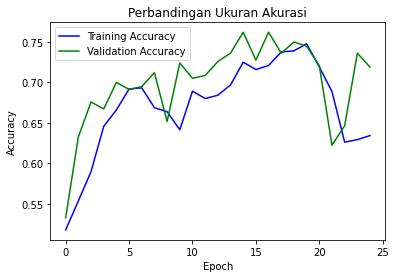

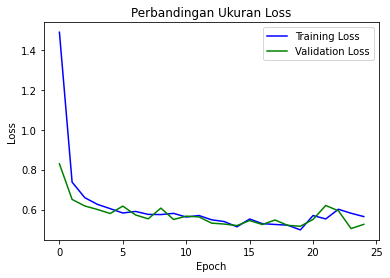

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history10.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history10.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history10.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history10.history['loss'], label='Training Loss', color='blue')
plt.plot(history10.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred10 = model10.predict_generator(test_generator9)
predictions10 = np.argmax(pred10, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator9.classes
class_labels = list(test_generator9.class_indices.keys())

In [ ]:
cn_matrix10 = confusion_matrix(true_classes, predictions10)
cn_matrix10

array([[52, 22],
       [52, 22]])

Text(0.5, 1.0, 'Confusion Matrix')

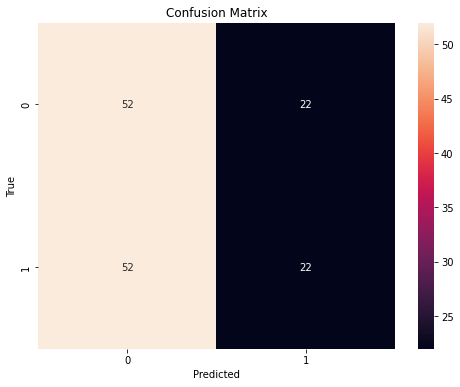

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix10, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions10, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.50      0.70      0.58        74
Non_Autistic       0.50      0.30      0.37        74

    accuracy                           0.50       148
   macro avg       0.50      0.50      0.48       148
weighted avg       0.50      0.50      0.48       148



## Resnet152

In [ ]:
res_152_model = resnet.ResNet152(input_shape=(224, 224, 3), include_top=False)

for layer in res_152_model.layers:
  layer.trainable = False
res_152_model.summary()

234708992/234698864 [==============================] - 2s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [ ]:
last_layer10 = res_152_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer10.output_shape)
last_output10 = last_layer10.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
x10 = tf.keras.layers.GlobalMaxPooling2D()(last_output10)
x10 = tf.keras.layers.Dense(64, activation='relu')(x10)
x10 = tf.keras.layers.Flatten()(x10)
x10 = tf.keras.layers.Dropout(0.5)(x10)
x10 = tf.keras.layers.Dense(512, activation='relu')(x10)                
x10 = tf.keras.layers.Dense(2, activation='softmax')(x10)           

# Append the dense network to the base model
model11 = Model(res_152_model.input, x10)    

# Print the model summary. See your dense network connected at the end.
model11.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model11.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc11 = ModelCheckpoint(filepath="Model11_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history11 = model11.fit(
    train_generator9, epochs=25, verbose=2, callbacks=[es, mc11], 
    validation_data=val_generator9, validation_steps=10)

Epoch 1/25
11/11 - 38s - loss: 1.0082 - accuracy: 0.5404 - val_loss: 0.6901 - val_accuracy: 0.6121 - 38s/epoch - 3s/step
Epoch 2/25
11/11 - 24s - loss: 0.7161 - accuracy: 0.5803 - val_loss: 0.6255 - val_accuracy: 0.6224 - 24s/epoch - 2s/step
Epoch 3/25
11/11 - 25s - loss: 0.6196 - accuracy: 0.6316 - val_loss: 0.5736 - val_accuracy: 0.6931 - 25s/epoch - 2s/step
Epoch 4/25
11/11 - 25s - loss: 0.6055 - accuracy: 0.6724 - val_loss: 0.5612 - val_accuracy: 0.7000 - 25s/epoch - 2s/step
Epoch 5/25
11/11 - 24s - loss: 0.5731 - accuracy: 0.6624 - val_loss: 0.5646 - val_accuracy: 0.7017 - 24s/epoch - 2s/step
Epoch 6/25
11/11 - 23s - loss: 0.5911 - accuracy: 0.6733 - val_loss: 0.5680 - val_accuracy: 0.7000 - 23s/epoch - 2s/step
Epoch 7/25
11/11 - 25s - loss: 0.5619 - accuracy: 0.6860 - val_loss: 0.5733 - val_accuracy: 0.7224 - 25s/epoch - 2s/step
Epoch 8/25
11/11 - 23s - loss: 0.5454 - accuracy: 0.7178 - val_loss: 0.5957 - val_accuracy: 0.7000 - 23s/epoch - 2s/step
Epoch 9/25
11/11 - 25s - loss: 0

In [ ]:
model11.evaluate(train_generator9)
model11.evaluate(val_generator9)
model11.evaluate(test_generator9)

11/11 [==============================] - 1s 127ms/step - loss: 0.4452 - accuracy: 0.8041


[0.4451700747013092, 0.8040540814399719]

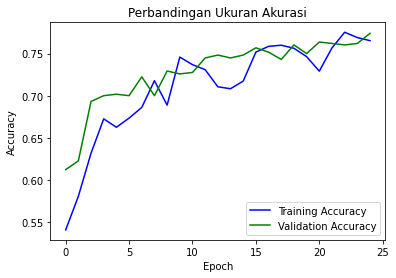

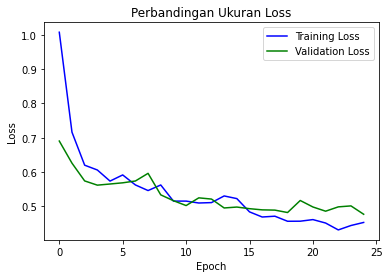

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history11.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history11.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history11.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history11.history['loss'], label='Training Loss', color='blue')
plt.plot(history11.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred11 = model11.predict_generator(test_generator9)
predictions11 = np.argmax(pred11, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator9.classes
class_labels = list(test_generator9.class_indices.keys())

In [ ]:
cn_matrix11 = confusion_matrix(true_classes, predictions11)
cn_matrix11

array([[40, 34],
       [43, 31]])

Text(0.5, 1.0, 'Confusion Matrix')

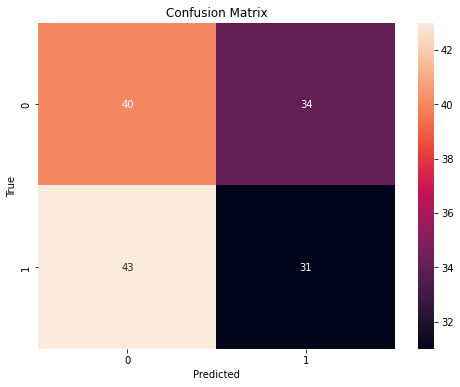

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix11, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions11, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.48      0.54      0.51        74
Non_Autistic       0.48      0.42      0.45        74

    accuracy                           0.48       148
   macro avg       0.48      0.48      0.48       148
weighted avg       0.48      0.48      0.48       148



## Resnet50 V2

In [ ]:
preprocess_input9 = resnet_v2.preprocess_input

train_datagen10 = ImageDataGenerator(preprocessing_function=preprocess_input9)
val_datagen10 = ImageDataGenerator(preprocessing_function=preprocess_input9)

train_generator10 = train_datagen10.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator10 = val_datagen10.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator10 = val_datagen10.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
res2_model = resnet_v2.ResNet50V2(input_shape=(224, 224, 3), include_top=False)

for layer in res2_model.layers:
  layer.trainable = False
res2_model.summary()

94683136/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
last_layer11 = res2_model.get_layer('post_relu')
print('last layer output shape: ', last_layer11.output_shape)
last_output11 = last_layer11.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
x11 = tf.keras.layers.GlobalMaxPooling2D()(last_output11)
x11 = tf.keras.layers.Dense(64, activation='relu')(x11)
x11 = tf.keras.layers.Flatten()(x11)
x11 = tf.keras.layers.Dropout(0.5)(x11)
x11 = tf.keras.layers.Dense(512, activation='relu')(x11)                
x11 = tf.keras.layers.Dense(2, activation='softmax')(x11)           

# Append the dense network to the base model
model12 = Model(res2_model.input, x11)    

# Print the model summary. See your dense network connected at the end.
model12.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model12.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc12 = ModelCheckpoint(filepath="Model12_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history12 = model12.fit(
    train_generator10, epochs=25, verbose=2, callbacks=[es, mc12], 
    validation_data=val_generator10, validation_steps=10)

Epoch 1/25
11/11 - 20s - loss: 1.1072 - accuracy: 0.5113 - val_loss: 0.6971 - val_accuracy: 0.4966 - 20s/epoch - 2s/step
Epoch 2/25
11/11 - 13s - loss: 0.6921 - accuracy: 0.5640 - val_loss: 0.6407 - val_accuracy: 0.6672 - 13s/epoch - 1s/step
Epoch 3/25
11/11 - 13s - loss: 0.6388 - accuracy: 0.5889 - val_loss: 0.6149 - val_accuracy: 0.6862 - 13s/epoch - 1s/step
Epoch 4/25
11/11 - 17s - loss: 0.6165 - accuracy: 0.6230 - val_loss: 0.5979 - val_accuracy: 0.7121 - 17s/epoch - 2s/step
Epoch 5/25
11/11 - 13s - loss: 0.6139 - accuracy: 0.6139 - val_loss: 0.6170 - val_accuracy: 0.6414 - 13s/epoch - 1s/step
Epoch 6/25
11/11 - 12s - loss: 0.6465 - accuracy: 0.6293 - val_loss: 0.6466 - val_accuracy: 0.6552 - 12s/epoch - 1s/step
Epoch 7/25
11/11 - 12s - loss: 0.6486 - accuracy: 0.6003 - val_loss: 0.6149 - val_accuracy: 0.6724 - 12s/epoch - 1s/step
Epoch 8/25
11/11 - 13s - loss: 0.5859 - accuracy: 0.6574 - val_loss: 0.5530 - val_accuracy: 0.7328 - 13s/epoch - 1s/step
Epoch 9/25
11/11 - 12s - loss: 0

In [ ]:
model12.evaluate(train_generator10)
model12.evaluate(val_generator10)
model12.evaluate(test_generator10)

11/11 [==============================] - 1s 58ms/step - loss: 0.4434 - accuracy: 0.8176


[0.44338706135749817, 0.8175675868988037]

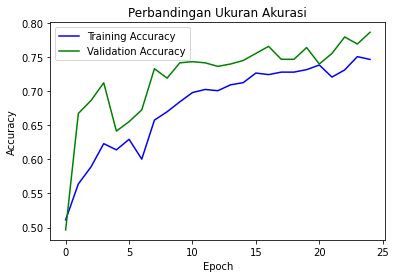

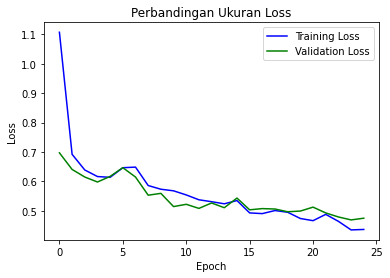

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history12.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history12.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history12.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history12.history['loss'], label='Training Loss', color='blue')
plt.plot(history12.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred12 = model12.predict_generator(test_generator10)
predictions12 = np.argmax(pred12, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator10.classes
class_labels = list(test_generator10.class_indices.keys())

In [ ]:
cn_matrix12 = confusion_matrix(true_classes, predictions12)
cn_matrix12

array([[37, 37],
       [34, 40]])

Text(0.5, 1.0, 'Confusion Matrix')

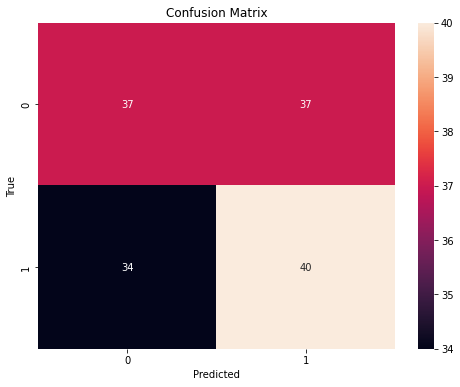

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix12, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions12, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.52      0.50      0.51        74
Non_Autistic       0.52      0.54      0.53        74

    accuracy                           0.52       148
   macro avg       0.52      0.52      0.52       148
weighted avg       0.52      0.52      0.52       148



## Resnet101 V2

In [ ]:
res2_101_model = resnet_v2.ResNet101V2(input_shape=(224, 224, 3), include_top=False)

for layer in res2_101_model.layers:
  layer.trainable = False
res2_101_model.summary()

171327488/171317808 [==============================] - 2s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
last_layer12 = res2_101_model.get_layer('post_relu')
print('last layer output shape: ', last_layer12.output_shape)
last_output12 = last_layer12.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
x12 = tf.keras.layers.GlobalMaxPooling2D()(last_output12)
x12 = tf.keras.layers.Dense(64, activation='relu')(x12)
x12 = tf.keras.layers.Flatten()(x12)
x12 = tf.keras.layers.Dropout(0.5)(x12)
x12 = tf.keras.layers.Dense(512, activation='relu')(x12)                
x12 = tf.keras.layers.Dense(2, activation='softmax')(x12)           

# Append the dense network to the base model
model13 = Model(res2_101_model.input, x12)    

# Print the model summary. See your dense network connected at the end.
model13.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model13.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc13 = ModelCheckpoint(filepath="Model13_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history13 = model13.fit(
    train_generator10, epochs=25, verbose=2, callbacks=[es, mc13], 
    validation_data=val_generator10, validation_steps=10)

Epoch 1/25
11/11 - 26s - loss: 1.1713 - accuracy: 0.5327 - val_loss: 0.6996 - val_accuracy: 0.5448 - 26s/epoch - 2s/step
Epoch 2/25
11/11 - 16s - loss: 0.6999 - accuracy: 0.5626 - val_loss: 0.6353 - val_accuracy: 0.6621 - 16s/epoch - 1s/step
Epoch 3/25
11/11 - 16s - loss: 0.6482 - accuracy: 0.6016 - val_loss: 0.6110 - val_accuracy: 0.6914 - 16s/epoch - 1s/step
Epoch 4/25
11/11 - 15s - loss: 0.6379 - accuracy: 0.6193 - val_loss: 0.5935 - val_accuracy: 0.6914 - 15s/epoch - 1s/step
Epoch 5/25
11/11 - 15s - loss: 0.6247 - accuracy: 0.6438 - val_loss: 0.5823 - val_accuracy: 0.7000 - 15s/epoch - 1s/step
Epoch 6/25
11/11 - 16s - loss: 0.5937 - accuracy: 0.6851 - val_loss: 0.5500 - val_accuracy: 0.7345 - 16s/epoch - 1s/step
Epoch 7/25
11/11 - 16s - loss: 0.5623 - accuracy: 0.7015 - val_loss: 0.5450 - val_accuracy: 0.7379 - 16s/epoch - 1s/step
Epoch 8/25
11/11 - 15s - loss: 0.5656 - accuracy: 0.6828 - val_loss: 0.5598 - val_accuracy: 0.7259 - 15s/epoch - 1s/step
Epoch 9/25
11/11 - 14s - loss: 0

In [ ]:
model13.evaluate(train_generator10)
model13.evaluate(val_generator10)
model13.evaluate(test_generator10)

11/11 [==============================] - 1s 87ms/step - loss: 0.4059 - accuracy: 0.7838


[0.4058666527271271, 0.7837837934494019]

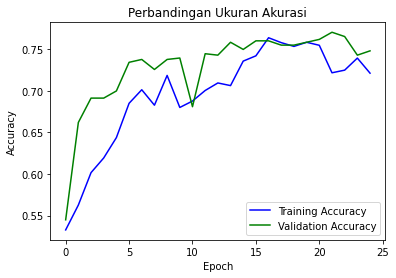

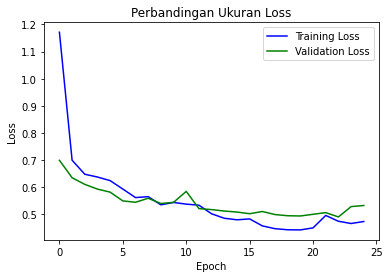

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history13.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history13.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history13.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history13.history['loss'], label='Training Loss', color='blue')
plt.plot(history13.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred13 = model13.predict_generator(test_generator10)
predictions13 = np.argmax(pred13, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator10.classes
class_labels = list(test_generator10.class_indices.keys())

In [ ]:
cn_matrix13 = confusion_matrix(true_classes, predictions13)
cn_matrix13

array([[42, 32],
       [46, 28]])

Text(0.5, 1.0, 'Confusion Matrix')

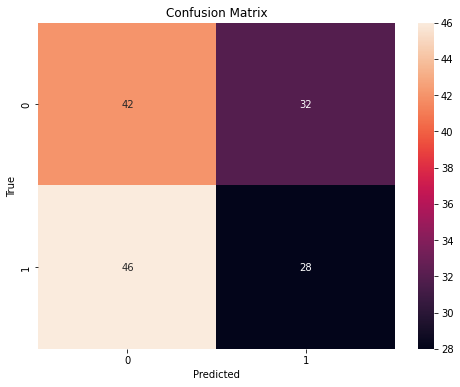

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix13, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions13, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.48      0.57      0.52        74
Non_Autistic       0.47      0.38      0.42        74

    accuracy                           0.47       148
   macro avg       0.47      0.47      0.47       148
weighted avg       0.47      0.47      0.47       148



## Xception

In [ ]:
preprocess_input10 = xception.preprocess_input

train_datagen11 = ImageDataGenerator(preprocessing_function=preprocess_input10)
val_datagen11 = ImageDataGenerator(preprocessing_function=preprocess_input10)

train_generator11 = train_datagen11.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=220
)

val_generator11 = val_datagen11.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=58
)

test_generator11 = val_datagen11.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=14
)

Found 2204 images belonging to 2 classes.
Found 588 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
xc_model = xception.Xception(input_shape=(224, 224, 3), include_top=False)

for layer in xc_model.layers:
  layer.trainable = False
xc_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
last_layer14 = xc_model.get_layer('block14_sepconv2_act')
print('last layer output shape: ', last_layer14.output_shape)
last_output14 = last_layer14.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
x14 = tf.keras.layers.GlobalMaxPooling2D()(last_output14)
x14 = tf.keras.layers.Dense(64, activation='relu')(x14)
x14 = tf.keras.layers.Flatten()(x14)
x14 = tf.keras.layers.Dropout(0.5)(x14)
x14 = tf.keras.layers.Dense(512, activation='relu')(x14)                
x14 = tf.keras.layers.Dense(2, activation='softmax')(x14)           

# Append the dense network to the base model
model15 = Model(xc_model.input, x14)    

# Print the model summary. See your dense network connected at the end.
model15.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
model15.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc15 = ModelCheckpoint(filepath="Model15_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history15 = model15.fit(
    train_generator11, epochs=25, verbose=2, callbacks=[es, mc15], 
    validation_data=val_generator11, validation_steps=10)

Epoch 1/25
11/11 - 28s - loss: 0.6740 - accuracy: 0.6157 - val_loss: 0.6237 - val_accuracy: 0.6741 - 28s/epoch - 3s/step
Epoch 2/25
11/11 - 16s - loss: 0.6209 - accuracy: 0.6606 - val_loss: 0.6130 - val_accuracy: 0.6638 - 16s/epoch - 1s/step
Epoch 3/25
11/11 - 14s - loss: 0.5869 - accuracy: 0.7005 - val_loss: 0.5755 - val_accuracy: 0.6879 - 14s/epoch - 1s/step
Epoch 4/25
11/11 - 14s - loss: 0.5676 - accuracy: 0.7055 - val_loss: 0.5925 - val_accuracy: 0.6793 - 14s/epoch - 1s/step
Epoch 5/25
11/11 - 15s - loss: 0.5514 - accuracy: 0.7132 - val_loss: 0.5669 - val_accuracy: 0.6983 - 15s/epoch - 1s/step
Epoch 6/25
11/11 - 14s - loss: 0.5441 - accuracy: 0.7223 - val_loss: 0.5554 - val_accuracy: 0.7310 - 14s/epoch - 1s/step
Epoch 7/25
11/11 - 14s - loss: 0.5382 - accuracy: 0.7232 - val_loss: 0.5484 - val_accuracy: 0.7190 - 14s/epoch - 1s/step
Epoch 8/25
11/11 - 13s - loss: 0.5333 - accuracy: 0.7182 - val_loss: 0.5539 - val_accuracy: 0.6897 - 13s/epoch - 1s/step
Epoch 9/25
11/11 - 14s - loss: 0

In [ ]:
model15.evaluate(train_generator11)
model15.evaluate(val_generator11)
model15.evaluate(test_generator11)

11/11 [==============================] - 2s 67ms/step - loss: 0.5085 - accuracy: 0.7432


[0.50850510597229, 0.7432432174682617]

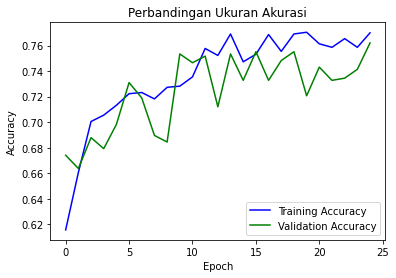

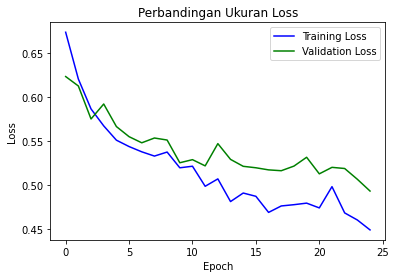

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history15.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history15.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history15.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history15.history['loss'], label='Training Loss', color='blue')
plt.plot(history15.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred15 = model15.predict_generator(test_generator11)
predictions15 = np.argmax(pred15, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator11.classes
class_labels = list(test_generator11.class_indices.keys())

In [ ]:
cn_matrix15 = confusion_matrix(true_classes, predictions15)
cn_matrix15

array([[36, 38],
       [44, 30]])

Text(0.5, 1.0, 'Confusion Matrix')

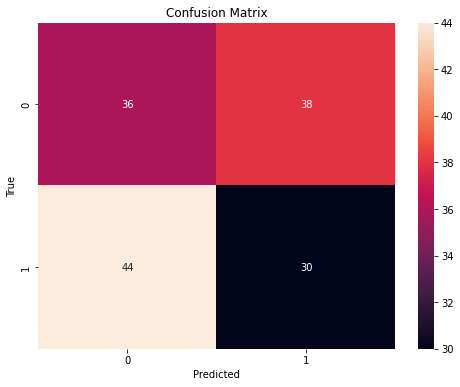

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix15, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions15)
print(cl_report)

              precision    recall  f1-score   support

           0       0.45      0.49      0.47        74
           1       0.44      0.41      0.42        74

    accuracy                           0.45       148
   macro avg       0.45      0.45      0.45       148
weighted avg       0.45      0.45      0.45       148



## Efficient Net B7

In [ ]:
en_B7_model = efficientnet.EfficientNetB7(input_shape=(224, 224, 3), include_top=False) 

for layer in en_B7_model.layers:
  layer.trainable = False
en_B7_model.summary()

258088960/258076736 [==============================] - 1s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                  

In [ ]:
last_layer15 = en_B7_model.get_layer('top_activation')
print('last layer output shape: ', last_layer15.output_shape)
last_output15 = last_layer15.output

last layer output shape:  (None, 7, 7, 2560)


In [ ]:
x15 = tf.keras.layers.GlobalMaxPooling2D()(last_output15)
x15 = tf.keras.layers.Dense(64, activation='relu')(x15)
x15 = tf.keras.layers.Flatten()(x15)
x15 = tf.keras.layers.Dropout(0.5)(x15)
x15 = tf.keras.layers.Dense(512, activation='relu')(x15)                
x15 = tf.keras.layers.Dense(2, activation='softmax')(x15)           

# Append the dense network to the base model
model16 = Model(en_B7_model.input, x15)    

# Print the model summary. See your dense network connected at the end.
model16.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                           

In [ ]:
model16.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mc16 = ModelCheckpoint(filepath="Model16_Best.h5", monitor="val_accuracy", save_best_only= True)

In [ ]:
history16 = model16.fit(
    train_generator3, epochs=25, verbose=2, callbacks=[es, mc16], 
    validation_data=val_generator3, validation_steps=10)

Epoch 1/25
11/11 - 65s - loss: 1.0615 - accuracy: 0.5150 - val_loss: 0.6986 - val_accuracy: 0.4793 - 65s/epoch - 6s/step
Epoch 2/25
11/11 - 34s - loss: 0.7253 - accuracy: 0.5227 - val_loss: 0.6249 - val_accuracy: 0.6552 - 34s/epoch - 3s/step
Epoch 3/25
11/11 - 31s - loss: 0.6579 - accuracy: 0.6130 - val_loss: 0.6138 - val_accuracy: 0.6500 - 31s/epoch - 3s/step
Epoch 4/25
11/11 - 32s - loss: 0.6428 - accuracy: 0.6239 - val_loss: 0.6482 - val_accuracy: 0.6121 - 32s/epoch - 3s/step
Epoch 5/25
11/11 - 34s - loss: 0.6389 - accuracy: 0.6216 - val_loss: 0.5966 - val_accuracy: 0.6879 - 34s/epoch - 3s/step
Epoch 6/25
11/11 - 33s - loss: 0.6170 - accuracy: 0.6470 - val_loss: 0.6049 - val_accuracy: 0.6948 - 33s/epoch - 3s/step
Epoch 7/25
11/11 - 32s - loss: 0.6260 - accuracy: 0.6388 - val_loss: 0.5823 - val_accuracy: 0.6810 - 32s/epoch - 3s/step
Epoch 8/25
11/11 - 32s - loss: 0.6113 - accuracy: 0.6370 - val_loss: 0.5985 - val_accuracy: 0.6879 - 32s/epoch - 3s/step
Epoch 9/25
11/11 - 32s - loss: 0

In [ ]:
model16.evaluate(train_generator3)
model16.evaluate(val_generator3)
model16.evaluate(test_generator3)

11/11 [==============================] - 3s 173ms/step - loss: 0.5399 - accuracy: 0.7973


[0.5398632287979126, 0.7972972989082336]

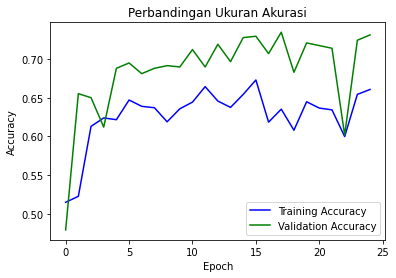

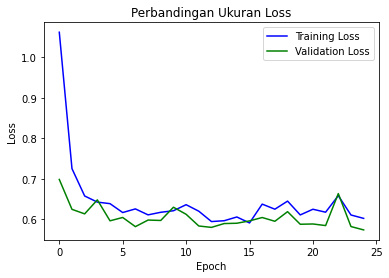

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history16.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history16.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history16.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history16.history['loss'], label='Training Loss', color='blue')
plt.plot(history16.history['val_loss'], label='Validation Loss', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred16 = model16.predict_generator(test_generator3)
predictions16 = np.argmax(pred16, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator3.classes
class_labels = list(test_generator3.class_indices.keys())

In [ ]:
cn_matrix16 = confusion_matrix(true_classes, predictions16)
cn_matrix16

array([[36, 38],
       [34, 40]])

Text(0.5, 1.0, 'Confusion Matrix')

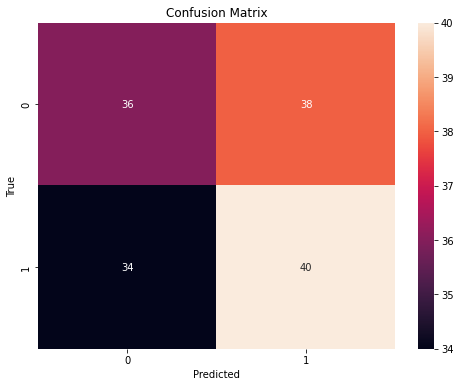

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix16, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [ ]:
cl_report = classification_report(true_classes, predictions16)
print(cl_report)

              precision    recall  f1-score   support

           0       0.51      0.49      0.50        74
           1       0.51      0.54      0.53        74

    accuracy                           0.51       148
   macro avg       0.51      0.51      0.51       148
weighted avg       0.51      0.51      0.51       148



# Fine Tuning

## Mobile Net

In [ ]:
load_mn = load_model('/content/Model5_Best.h5')
for layer in load_mn.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = False
  else:
    layer.trainables = True

In [ ]:
mc_mn = ModelCheckpoint('mobilenet.h5', save_best_only=True)
load_mn.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
load_mn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
history5_v2 = load_mn.fit(
    train_generator5, epochs=25, verbose=2, callbacks=[mc_mn], 
    validation_data=val_generator5, validation_steps=10)

Epoch 1/25
11/11 - 12s - loss: 0.3596 - accuracy: 0.8353 - val_loss: 0.4447 - val_accuracy: 0.7931 - 12s/epoch - 1s/step
Epoch 2/25
11/11 - 11s - loss: 0.3492 - accuracy: 0.8453 - val_loss: 0.4360 - val_accuracy: 0.8000 - 11s/epoch - 967ms/step
Epoch 3/25
11/11 - 10s - loss: 0.3362 - accuracy: 0.8503 - val_loss: 0.4564 - val_accuracy: 0.7810 - 10s/epoch - 951ms/step
Epoch 4/25
11/11 - 10s - loss: 0.3412 - accuracy: 0.8457 - val_loss: 0.4564 - val_accuracy: 0.7862 - 10s/epoch - 952ms/step
Epoch 5/25
11/11 - 11s - loss: 0.3142 - accuracy: 0.8584 - val_loss: 0.4470 - val_accuracy: 0.7966 - 11s/epoch - 986ms/step
Epoch 6/25
11/11 - 10s - loss: 0.3186 - accuracy: 0.8643 - val_loss: 0.4655 - val_accuracy: 0.7983 - 10s/epoch - 945ms/step
Epoch 7/25
11/11 - 10s - loss: 0.3090 - accuracy: 0.8589 - val_loss: 0.4453 - val_accuracy: 0.7966 - 10s/epoch - 948ms/step
Epoch 8/25
11/11 - 10s - loss: 0.3215 - accuracy: 0.8525 - val_loss: 0.4565 - val_accuracy: 0.8000 - 10s/epoch - 948ms/step
Epoch 9/25


In [ ]:
load_mn.evaluate(train_generator5)
load_mn.evaluate(val_generator5)
load_mn.evaluate(test_generator5)

11/11 [==============================] - 1s 56ms/step - loss: 0.4372 - accuracy: 0.7973


[0.4371584951877594, 0.7972972989082336]

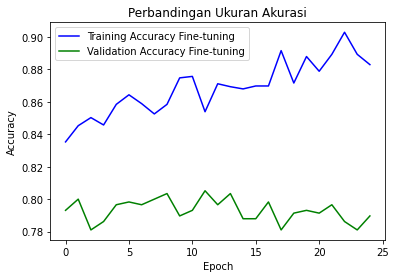

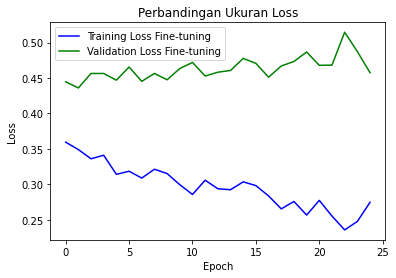

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history5_v2.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history5_v2.history['accuracy'], label='Training Accuracy Fine-tuning', color='blue')
plt.plot(history5_v2.history['val_accuracy'], label='Validation Accuracy Fine-tuning', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history5_v2.history['loss'], label='Training Loss Fine-tuning', color='blue')
plt.plot(history5_v2.history['val_loss'], label='Validation Loss Fine-tuning', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred5_v2 = load_mn.predict_generator(test_generator5)
predictions5_v2 = np.argmax(pred5_v2, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator5.classes
class_labels = list(test_generator5.class_indices.keys())

In [ ]:
cn_matrix5_v2 = confusion_matrix(true_classes, predictions5_v2)
cn_matrix5_v2

array([[45, 29],
       [37, 37]])

In [ ]:
cl_report = classification_report(true_classes, predictions5_v2, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.55      0.61      0.58        74
Non_Autistic       0.56      0.50      0.53        74

    accuracy                           0.55       148
   macro avg       0.55      0.55      0.55       148
weighted avg       0.55      0.55      0.55       148



## Mobile Net V2

In [ ]:
load_mn2 = load_model('/content/Model6_Best.h5')
for layer in load_mn2.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = False
  else:
    layer.trainables = True

In [ ]:
mc_mn2 = ModelCheckpoint('mobilenetv2.h5', save_best_only=True)
load_mn2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
load_mn2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
history6_v2 = load_mn2.fit(
    train_generator6, epochs=25, verbose=2, callbacks=[mc_mn2], 
    validation_data=val_generator6, validation_steps=10) 

Epoch 1/25
11/11 - 14s - loss: 0.4055 - accuracy: 0.8181 - val_loss: 0.4651 - val_accuracy: 0.7552 - 14s/epoch - 1s/step
Epoch 2/25
11/11 - 11s - loss: 0.3757 - accuracy: 0.8312 - val_loss: 0.4511 - val_accuracy: 0.7741 - 11s/epoch - 990ms/step
Epoch 3/25
11/11 - 11s - loss: 0.3732 - accuracy: 0.8398 - val_loss: 0.4551 - val_accuracy: 0.7914 - 11s/epoch - 963ms/step
Epoch 4/25
11/11 - 11s - loss: 0.3650 - accuracy: 0.8376 - val_loss: 0.4315 - val_accuracy: 0.7966 - 11s/epoch - 998ms/step
Epoch 5/25
11/11 - 11s - loss: 0.3418 - accuracy: 0.8439 - val_loss: 0.4544 - val_accuracy: 0.7914 - 11s/epoch - 969ms/step
Epoch 6/25
11/11 - 11s - loss: 0.3249 - accuracy: 0.8580 - val_loss: 0.4434 - val_accuracy: 0.7948 - 11s/epoch - 1s/step
Epoch 7/25
11/11 - 11s - loss: 0.3214 - accuracy: 0.8566 - val_loss: 0.4607 - val_accuracy: 0.7879 - 11s/epoch - 970ms/step
Epoch 8/25
11/11 - 11s - loss: 0.2975 - accuracy: 0.8702 - val_loss: 0.4766 - val_accuracy: 0.7862 - 11s/epoch - 960ms/step
Epoch 9/25
11/

In [ ]:
load_mn2.evaluate(train_generator6)
load_mn2.evaluate(val_generator6)
load_mn2.evaluate(test_generator6)

11/11 [==============================] - 2s 158ms/step - loss: 0.6354 - accuracy: 0.8041


[0.6353660225868225, 0.8040540814399719]

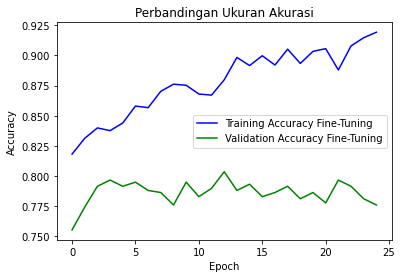

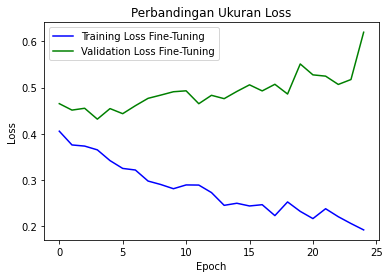

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history6_v2.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history6_v2.history['accuracy'], label='Training Accuracy Fine-Tuning', color='blue')
plt.plot(history6_v2.history['val_accuracy'], label='Validation Accuracy Fine-Tuning', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history6_v2.history['loss'], label='Training Loss Fine-Tuning', color='blue')
plt.plot(history6_v2.history['val_loss'], label='Validation Loss Fine-Tuning', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
pred6_v2 = load_mn2.predict_generator(test_generator6)
predictions6_v2 = np.argmax(pred6_v2, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
true_classes = test_generator6.classes
class_labels = list(test_generator6.class_indices.keys())  

In [ ]:
cn_matrix6_v2 = confusion_matrix(true_classes, predictions6_v2)
cn_matrix6_v2

array([[40, 34],
       [29, 45]])

In [ ]:
cl_report = classification_report(true_classes, predictions6_v2, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.58      0.54      0.56        74
Non_Autistic       0.57      0.61      0.59        74

    accuracy                           0.57       148
   macro avg       0.57      0.57      0.57       148
weighted avg       0.57      0.57      0.57       148



## Resnet101 V2

In [ ]:
load_res101_v2 = load_model('/content/Model13_Best.h5')
for layer in load_res101_v2.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = False
  else:
    layer.trainables = True

In [ ]:
mc_res101_v2 = ModelCheckpoint('resnet101_v2.h5', save_best_only=True)
load_res101_v2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
load_res101_v2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
history13_v2 = load_res101_v2.fit(
    train_generator10, epochs=25, verbose=2, callbacks=[mc_res101_v2], 
    validation_data=val_generator10, validation_steps=10)

Epoch 1/25
11/11 - 27s - loss: 0.4472 - accuracy: 0.7532 - val_loss: 0.5823 - val_accuracy: 0.7690 - 27s/epoch - 2s/step
Epoch 2/25
11/11 - 17s - loss: 0.4098 - accuracy: 0.7536 - val_loss: 0.5379 - val_accuracy: 0.7638 - 17s/epoch - 2s/step
Epoch 3/25
11/11 - 16s - loss: 0.4111 - accuracy: 0.7432 - val_loss: 0.5348 - val_accuracy: 0.7569 - 16s/epoch - 1s/step
Epoch 4/25
11/11 - 15s - loss: 0.3961 - accuracy: 0.7418 - val_loss: 0.6444 - val_accuracy: 0.7638 - 15s/epoch - 1s/step
Epoch 5/25
11/11 - 20s - loss: 0.4219 - accuracy: 0.7495 - val_loss: 0.5599 - val_accuracy: 0.7776 - 20s/epoch - 2s/step
Epoch 6/25
11/11 - 22s - loss: 0.4215 - accuracy: 0.7559 - val_loss: 0.5514 - val_accuracy: 0.7655 - 22s/epoch - 2s/step
Epoch 7/25
11/11 - 17s - loss: 0.4175 - accuracy: 0.7355 - val_loss: 0.5440 - val_accuracy: 0.7552 - 17s/epoch - 2s/step
Epoch 8/25
11/11 - 14s - loss: 0.3798 - accuracy: 0.7618 - val_loss: 0.5550 - val_accuracy: 0.7776 - 14s/epoch - 1s/step
Epoch 9/25
11/11 - 16s - loss: 0

In [ ]:
load_res101_v2.evaluate(train_generator10)
load_res101_v2.evaluate(val_generator10)
load_res101_v2.evaluate(test_generator10)

11/11 [==============================] - 1s 83ms/step - loss: 0.6559 - accuracy: 0.7905


[0.655947744846344, 0.7905405163764954]

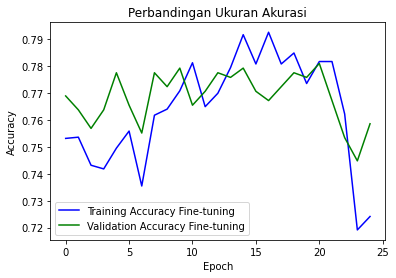

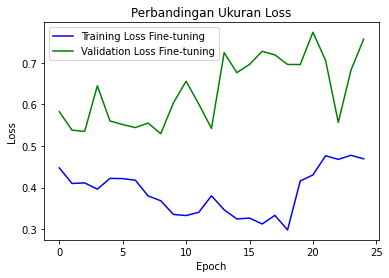

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
epochs = range(len(history13_v2.history['accuracy']))

#Plot training and validation accuracy per epoch
plt.plot(epochs, history13_v2.history['accuracy'], label='Training Accuracy Fine-tuning', color='blue')
plt.plot(history13_v2.history['val_accuracy'], label='Validation Accuracy Fine-tuning', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, history13_v2.history['loss'], label='Training Loss Fine-tuning', color='blue')
plt.plot(history13_v2.history['val_loss'], label='Validation Loss Fine-tuning', color='green')
plt.title('Perbandingan Ukuran Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
## change model
pred13_v2 = load_res101_v2.predict_generator(test_generator10)
predictions13_v2 = np.argmax(pred13_v2, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
true_classes = test_generator10.classes
class_labels = list(test_generator10.class_indices.keys())

In [ ]:
cn_matrix13_v2 = confusion_matrix(true_classes, predictions13_v2)
cn_matrix13_v2

array([[35, 39],
       [36, 38]])

In [ ]:
cl_report = classification_report(true_classes, predictions13_v2, target_names=class_labels)
print(cl_report)

              precision    recall  f1-score   support

    Autistic       0.49      0.47      0.48        74
Non_Autistic       0.49      0.51      0.50        74

    accuracy                           0.49       148
   macro avg       0.49      0.49      0.49       148
weighted avg       0.49      0.49      0.49       148



# Deployment

In [ ]:
model_path = tempfile.gettempdir()

version = 1
export_model = os.path.join(model_path, str(version))

if os.path.isdir(export_model):
    print('\nPath already exist')
    !rm -r {export_model}

model6.save(export_model, save_format="tf")

print('\nexport_model = {}'.format(export_model))
!ls -l {export_model}

In [ ]:
tf_converter = tf.lite.TFLiteConverter.from_saved_model(export_model)
tf_converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
tflite_convert = tf_converter.convert()
tflite_file = 'mobilenetv2_02.tflite'
with open(tflite_file, 'wb') as x:
  x.write(tflite_convert)